In [1]:
!git clone https://github.com/NGOVANMANH/DataMiningProject.git

Cloning into 'DataMiningProject'...
remote: Enumerating objects: 25040, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 25040 (delta 6), reused 21 (delta 5), pack-reused 25017
Receiving objects: 100% (25040/25040), 542.18 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (75009/75009), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
import cv2
import os

In [3]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH = 32

In [4]:
# Set the paths to the datasets
train_dir = '/content/DataMiningProject/dataset/train'
test_dir = '/content/DataMiningProject/dataset/test'


In [5]:
# Load pre-trained MobileNet model + feature extractor
base_model = MobileNet(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

17225924/17225924 [==============================] - 0s 0us/step


In [6]:
# Function to preprocess and extract features from an image directory in batches
def extract_features_batch(directory, batch_size=BATCH, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    features = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        image_paths = [os.path.join(label_dir, image_path) for image_path in os.listdir(label_dir)]
        num_images = len(image_paths)
        for i in range(0, num_images, batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []
            for image_path in batch_paths:
                img = load_img(image_path, target_size=target_size)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                batch_images.append(img_array)
            batch_images = np.array(batch_images)
            batch_features = model.predict(batch_images)
            features.extend(batch_features)
            labels.extend([label] * len(batch_features))
    return np.array(features), np.array(labels)

In [7]:
# Extract features and labels from train and test sets
train_features, train_labels = extract_features_batch(train_dir)
test_features, test_labels = extract_features_batch(test_dir)


1/1 [==============================] - 1s 547ms/step


In [8]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)

In [9]:
X_train_scaled.shape

(21000, 1024)

In [19]:
# Sử dụng SVM để phân loại
svm = SVC(kernel='linear', random_state=42, probability=True)
svm.fit(train_features, train_labels)

SVC(kernel='linear', probability=True, random_state=42)

In [20]:
# Dự đoán và đánh giá mô hình
y_pred_train = svm.predict(train_features)
y_pred_test = svm.predict(test_features)

In [21]:
# Tính độ chính xác
train_accuracy = accuracy_score(train_labels, y_pred_train)
test_accuracy = accuracy_score(test_labels, y_pred_test)
print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')

Training accuracy: 1.0
Test accuracy: 0.98425


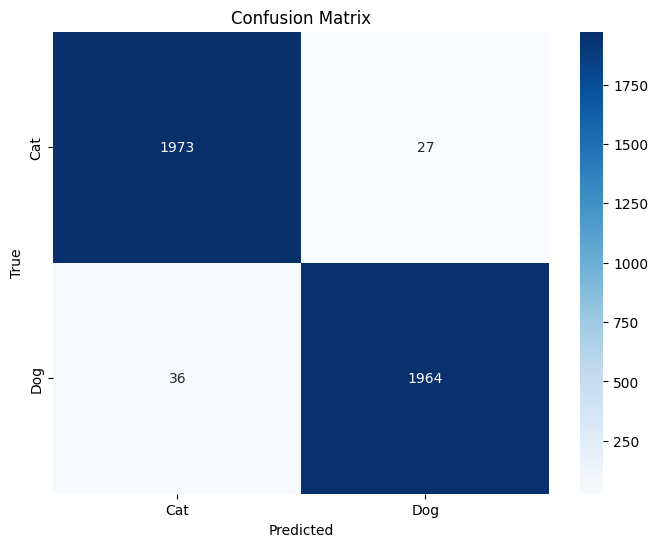

In [22]:

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(test_labels, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Hàm để lấy ảnh từ một thư mục
def load_images_from_directory(directory, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        image_paths = [os.path.join(label_dir, image_path) for image_path in os.listdir(label_dir)]
        for image_path in image_paths:
            img = load_img(image_path, target_size=target_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

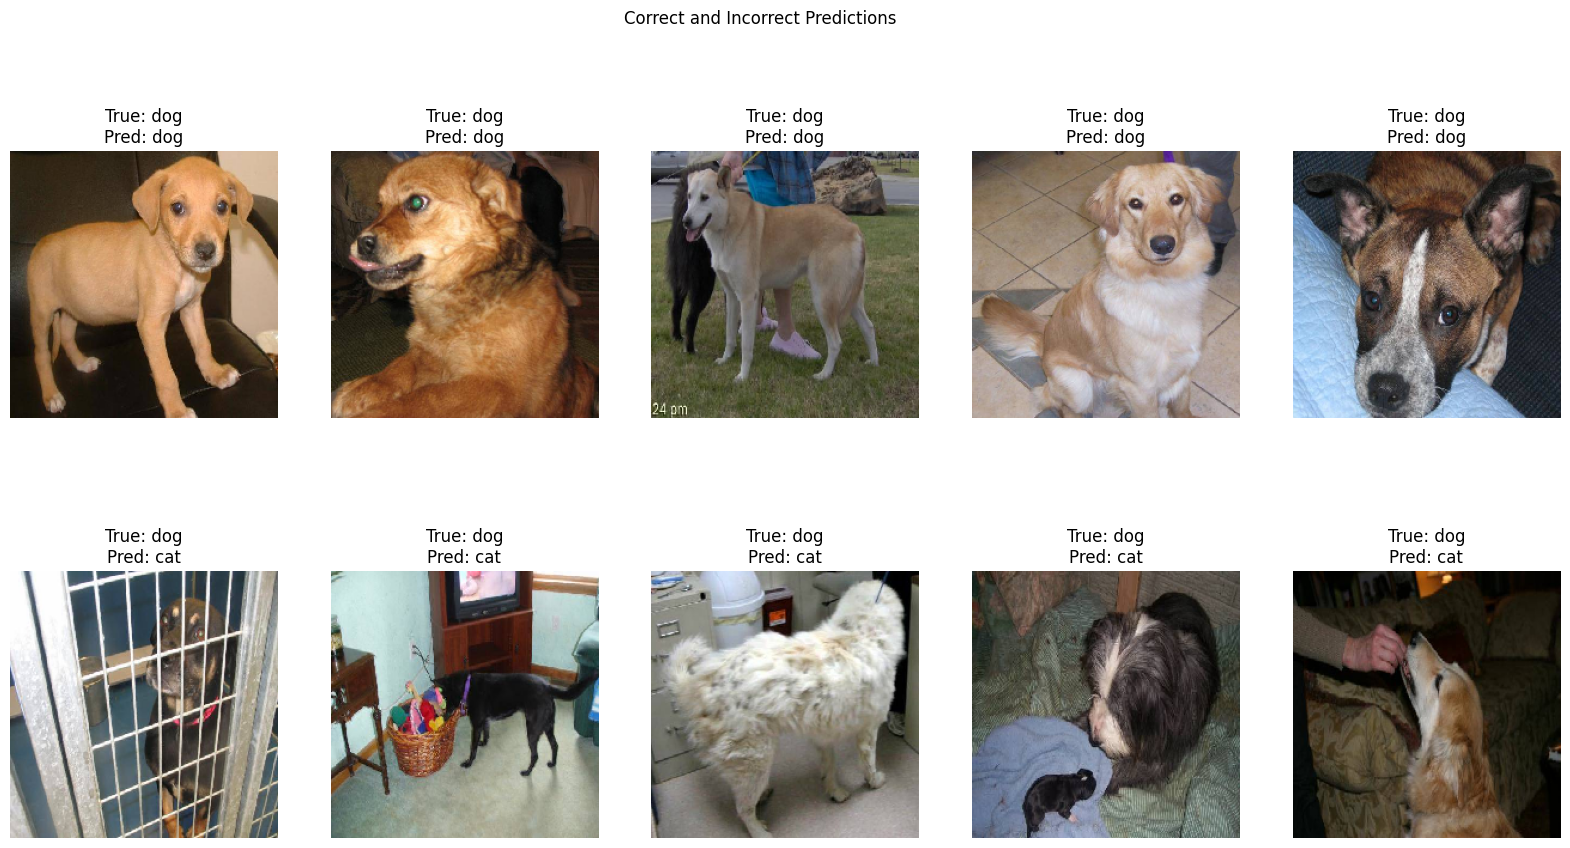

In [24]:
# Hiển thị một số hình ảnh dự đoán đúng và sai
def display_predictions(images, labels, predictions, title):
    correct = [i for i, (true, pred) in enumerate(zip(labels, predictions)) if true == pred]
    incorrect = [i for i, (true, pred) in enumerate(zip(labels, predictions)) if true != pred]

    plt.figure(figsize=(20, 10))  # Tăng kích thước hiển thị hình ảnh
    plt.suptitle(title)
    for i, idx in enumerate(correct[:5]):
        plt.subplot(2, 5, i + 1)
        img = images[idx]
        img = img.astype(np.uint8)  # Chuyển đổi về kiểu uint8 để hiển thị đúng màu
        plt.imshow(img.astype(np.uint8))  # Hiển thị ảnh ở định dạng RGB
        plt.title(f'True: {labels[idx]}\nPred: {predictions[idx]}')
        plt.axis('off')

    for i, idx in enumerate(incorrect[:5]):
        plt.subplot(2, 5, i + 6)
        img = images[idx]
        img = img.astype(np.uint8)  # Chuyển đổi về kiểu uint8 để hiển thị đúng màu
        plt.imshow(img.astype(np.uint8))  # Hiển thị ảnh ở định dạng RGB
        plt.title(f'True: {labels[idx]}\nPred: {predictions[idx]}')
        plt.axis('off')

# Sử dụng hàm hiển thị
test_images, test_labels = load_images_from_directory(test_dir)
display_predictions(test_images, test_labels, y_pred_test, 'Correct and Incorrect Predictions')

plt.show()

In [25]:
# Function to predict the class and max score from an input image path
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(img_array)

    # Predict the class
    prediction = svm.predict(features)
    # Predict probabilities for each class
    prediction_proba = svm.predict_proba(features)

    # Get the maximum probability for the predicted class
    max_score = np.max(prediction_proba)

    return prediction[0], max_score

In [26]:
# Example usage
image_path = '/content/DataMiningProject/samples/dog.jpg'
predicted_class, max_score = predict_image(image_path)
print(f'The predicted class for the image is: {predicted_class}')
print(f'The confidence score for the prediction is: {max_score*100:.2f} %')

1/1 [==============================] - 0s 171ms/step
The predicted class for the image is: dog
The confidence score for the prediction is: 100.00 %


In [36]:
# Example usage
image_path = '/content/DataMiningProject/samples/cat.jpg'
predicted_class, max_score = predict_image(image_path)
print(f'The predicted class for the image is: {predicted_class}')
print(f'The confidence score for the prediction is: {max_score*100:.2f} %')

1/1 [==============================] - 0s 101ms/step
The predicted class for the image is: cat
The confidence score for the prediction is: 100.00 %
